# Use machine learning to predict ENSO 

The El Nino Southern Oscillation (ENSO) is a decadal climate cycle that leads to unusually warm, rainy weather in some regions and cold, dry weather in others, depending on its phase.

This notebook implements machine learning on 11-yr demeaned weaather data between 2008-2018 from the NOAA GSOD dataset. The machine learning labels are formed from the National Weather Service Climate Prediction Center's (CPC) Monthly Nino 3.4 Index. The index is an anomaly from the 30-yr mean period 1986-2015.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.basemap import Basemap
#import geoplot
import matplotlib.pyplot as plt

# ML packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Station importance by temperature
### Which stations are most informative in predicting the El Nino 3.4 index? (see real answer here: https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/nino_regions.shtml)

Sea Surface Temperature (SST) is a strong indicator of El Nino, so let's start by using only temperature at all stations. 

After, we'll run a Random Forest regressor to learn and predict the relationship between temperature and ElNino3.4, then see which features (stations) it gives the highest importance.

In [2]:
dataset_path = '/datasets/NOAA_SST/'
fpath = dataset_path + 'noaa_gsod/'

# # LOAD DATA # #
df_anom = pd.read_pickle(dataset_path + 'noaa_gsod_preprocessed') # # climate data
stations = pd.read_pickle(dataset_path + 'noaa_gsod.stations')

dnino = pd.read_csv('monthly.nino3.4.txt') # # El Nino 3.4 indicator
dnino['Datetime'] = pd.to_datetime((dnino['YR'].astype(str) + dnino['MON'].astype(str)), format='%Y%m') 
dnino = dnino.loc[dnino['Datetime'] >= pd.Timestamp(2008,1,1)] # Only since 2008 (matches weather data)
dnino = dnino.set_index('Datetime',drop=True) # Make the datetime index

# # # MAKE FEATURE DATAFRAME # #
# form station-wise columns (for feature analysis)
temp_feat = pd.DataFrame()
temp_feat['Datetime'] = df_anom.index.values # make new column
temp_feat['stn'] = df_anom['stn'].values # make new column
temp_feat['temp'] = df_anom['temp'].values # make new column

temp_feat = temp_feat.pivot(columns='stn', index='Datetime', values='temp') # convert station numbers as new columns
temp_feat = temp_feat.dropna(axis=1) # remove stations with nans

# # MAKE LABEL # #
ylabel = dnino['ANOM']

print( '%5d samples, %4d features' % (len(temp_feat), len(temp_feat.columns)-1) )

  132 samples, 3905 features


This data has many more features than samples. The main reason is that the monthly average is used to compare with monthly Nino 3.4 index. And there are a ton of stations! By finding the most important stations, we can reduce the features and hopefully improve the model.

The data is chronological. We'll split the training data by time. From that, we select a validation set to tune our hyperparameters.

In [3]:
# Use 20% test split (80% training + validation)
ntrain = int(len(temp_feat)*0.5)
x_test = temp_feat.iloc[ntrain:,:]
y_test = ylabel[ntrain:]

# Split remaining 80% into training-validation sets by 60%/20% (of original data)
x_train = temp_feat.iloc[0:ntrain,:]
y_train = ylabel[0:ntrain]
#x_train, x_val, y_train, y_val = train_test_split(temp_feat.iloc[0:ntrain,:], ylabel[0:ntrain], \
#                                                    test_size=0, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
#x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

## Random Forest feature importance

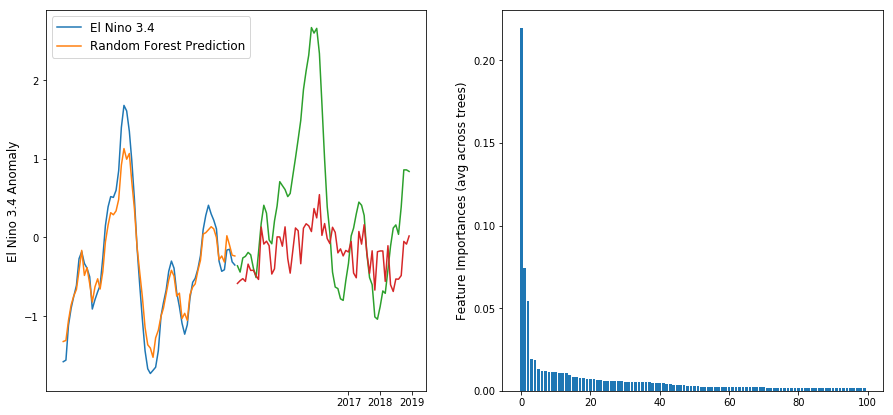

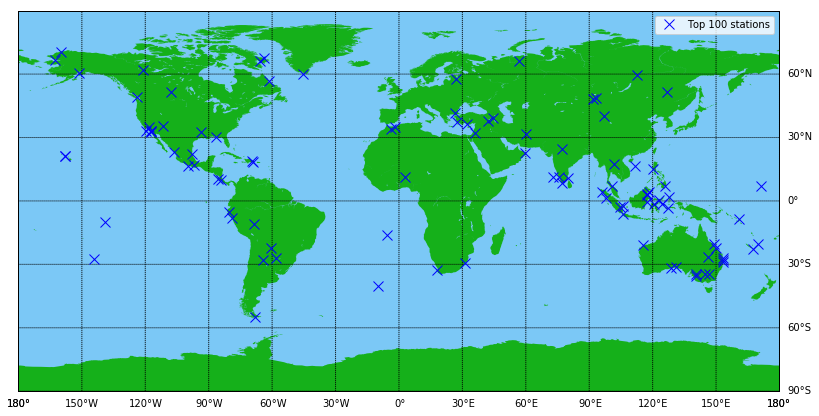

In [4]:
clf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0) # define the random forest object
clf.fit(x_train, y_train) # train random forest
yt = clf.predict(x_train)
y = clf.predict(x_test) # predict the El Nino 3.4

# plot predictions
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(temp_feat.iloc[0:ntrain].index, y_train) # plot the training El Nino 3.4
plt.plot(temp_feat.iloc[0:ntrain].index, yt) # plot the training El Nino 3.4

plt.plot(temp_feat.iloc[ntrain:].index,y_test) # plot the true El Nino 3.4
plt.plot(temp_feat.iloc[ntrain:].index, y) # plot the predicted El Nino 3.4
plt.gca().set_xticks((pd.Timestamp(2017,1,1), pd.Timestamp(2018,1,1), pd.Timestamp(2019,1,1))) # make x-axis in years
plt.ylabel('El Nino 3.4 Anomaly',fontsize=12)
plt.legend(('El Nino 3.4','Random Forest Prediction'), fontsize=12)
#plt.show()

# # Plot the feature importances # #
nfeatures = 100
fi = clf.feature_importances_
fi_sort = np.argsort(fi)[::-1] # sort the feature importances most to least
plt.subplot(1,2,2)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]]) # plot the feature importances
plt.ylabel('Feature Importances (avg across trees)', fontsize=12)
plt.show()

# # Show top 'nfeatures' stations on world map # #
top_stations = [x for x in temp_feat.iloc[:,fi_sort[0:nfeatures]].columns]
lat = [stations['lat'].loc[stations['usaf'] == t].values[0] for t in top_stations] # find where the top stations are
lon = [stations['lon'].loc[stations['usaf'] == t].values[0] for t in top_stations]

fig = plt.figure(figsize=(15,7))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(0.,350.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
#xpt,ypt = m(lon,lat)
p1, = plt.plot(lon,lat,'bx', markersize=10)
plt.legend([p1],['Top ' + str(nfeatures) + ' stations'])
plt.show()

## Save the data for top stations ##

Now that we've learned which stations are more important (by temperature), let's reduce our original features to only those stations, but we'll keep all weather measurements. 

#### Bonus Question: What happens if we change the number of stations kept?

In [5]:
df_top = df_anom[df_anom['stn'].isin(top_stations)]
df_top.to_pickle('Top_Stations_noaa_gsod')